仿造Kaggle上的做法，但這邊還需要加入  
* 比較只挑選5個特徵跟全部特徵的預測結果。

1. 讀檔

In [193]:
import pandas as pd
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

df = read_csv('HW2_house-prices.csv')



df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [194]:
ID = df['Id']   # 先留者之後寫入csv
# 因為ID欄位不需要，所以刪除
df = df.drop(columns=['Id'])

2. 預測資料是否為常態分布?

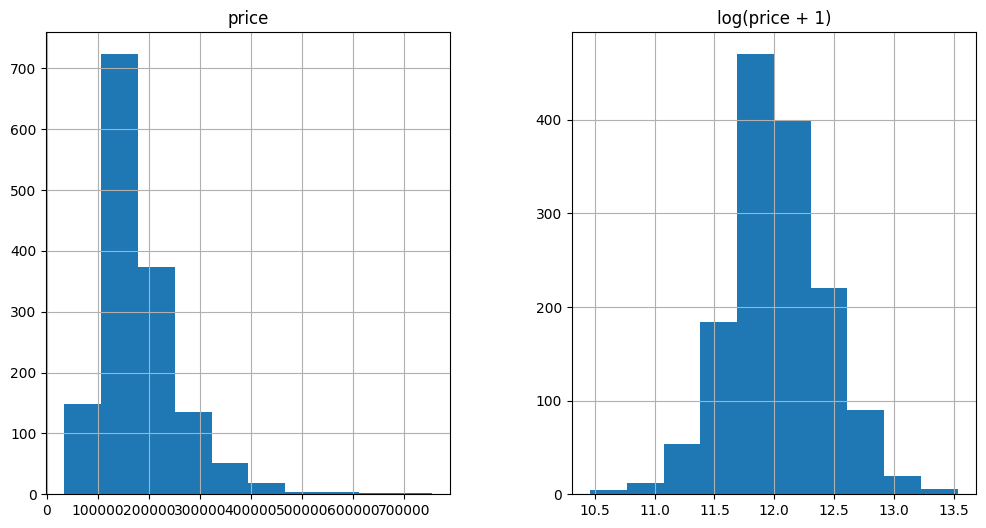

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def distribution_plot(df):
    matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
    prices = pd.DataFrame({"price":df["SalePrice"], "log(price + 1)":np.log1p(df["SalePrice"])})
    prices.hist()

distribution_plot(df)

根據結果，發現原始資料並不是常態分布而是Skew-distribution，於是需要做數據平滑  
y = log (1 + p)

In [196]:
def data_transfrom(df):
    df["SalePrice"] = np.log1p(df["SalePrice"])
    return df

# 對於偏斜度過大的資料，進行log1p轉換
from scipy.stats import skew
def skew_transform(df):
    features = df.copy().drop('SalePrice', axis=1)
    # 找出數值型特徵
    numeric_feats = features.dtypes[features.dtypes != "object"].index
    skewed_feats = features[numeric_feats].apply(lambda x: skew(x.dropna()))
    # 找出符合條件的特徵，在進行轉換
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    features[skewed_feats] = np.log1p(features[skewed_feats])
    df = pd.concat([df['SalePrice'], features], axis=1)
    return df

df = data_transfrom(df)
df = skew_transform(df)
df.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,12.247699,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,12.109016,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,12.317171,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,11.849405,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,12.429220,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


3. 分析缺失值

In [197]:
#missing data
def analysis_missing_data(df):
    # 缺失值在每行的個數
    total = df.isnull().sum().sort_values(ascending=False)
    # 缺失值在每行的比例
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data = analysis_missing_data(df)
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


4. 超過20%的就不看，其他用平均值取代缺失值

In [198]:
def drop_missing_data(df):
    del_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    df = df.drop(del_col, axis=1)
    # 选择数值列
    numeric_cols = df.select_dtypes(include=['number'])
    # 填充缺失值
    numeric_cols_filled = numeric_cols.fillna(numeric_cols.mean())
    # 将填充后的数值列与非数值列合并
    df = pd.concat([numeric_cols_filled, df.select_dtypes(exclude=['number'])], axis=1)

    return df

df = drop_missing_data(df)
df.head()

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,12.247699,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,12.109016,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,12.317171,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,11.849405,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,12.429220,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


5. 處理類別資料

In [199]:
from sklearn.preprocessing import LabelEncoder
def cat_seqence(dataframe, col_name):
    categorical_columns = {}
    for col in col_name:
        counts = dataframe[col].value_counts() # 資料,個數
        categorical_columns[col] = counts.index.tolist()
    return categorical_columns

def label_encoding(df, col_name):
    for c, order in col_name.items():
        lbl = LabelEncoder()
        features = df.copy().drop('SalePrice', axis=1)
        # 將類別順序應用於列
        features[c] = pd.Categorical(features[c], categories=order, ordered=True)
        # 按指定順序轉成label encoding
        features[c] = lbl.fit_transform(features[c])
        df = pd.concat([df['SalePrice'], features], axis=1)
    return df

catrgorical = df.copy().drop(['SalePrice'], axis=1).select_dtypes(exclude=["number"]).columns
catrgorical_columns = cat_seqence(df, catrgorical)
df = label_encoding(df, catrgorical_columns)
df.head()

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,12.247699,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,4,2,6,1,1,4,4,2,8,4
1,12.109016,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,4,3,6,1,1,4,4,2,8,4
2,12.317171,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,4,2,6,1,1,4,4,2,8,4
3,11.849405,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,4,2,6,5,2,4,4,2,8,0
4,12.429220,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,4,2,6,1,1,4,4,2,8,4


6. model (先餵全部資料在找重要特徵)

In [200]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

features = df.drop(['SalePrice'], axis=1)
prices = df['SalePrice']

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(features, prices, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# 讀取數據 (DMatrix為xgboost專用的數據格式，可以優化訓練過程)
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
dtest = xgb.DMatrix(features)

# 設置參數
params = {
    "max_depth":5, 
    "eta":0.1, 
    "colsample_bytree":0.8, 
    "subsample":0.8, 
    "objective": "reg:squarederror"  # 設置為回歸任務
}
# 訓練模型
model = xgb.train(params=params, dtrain=dtrain,  num_boost_round=500, 
                  early_stopping_rounds=100, evals=[(dvalid, 'valid')])

# 預測
result = model.predict(dtest)

[0]	valid-rmse:0.35742
[1]	valid-rmse:0.32996
[2]	valid-rmse:0.30789
[3]	valid-rmse:0.28624
[4]	valid-rmse:0.26778
[5]	valid-rmse:0.24974
[6]	valid-rmse:0.23463
[7]	valid-rmse:0.22160
[8]	valid-rmse:0.20889
[9]	valid-rmse:0.19814
[10]	valid-rmse:0.18998
[11]	valid-rmse:0.18260
[12]	valid-rmse:0.17527
[13]	valid-rmse:0.17028
[14]	valid-rmse:0.16496
[15]	valid-rmse:0.16024
[16]	valid-rmse:0.15640
[17]	valid-rmse:0.15323
[18]	valid-rmse:0.15056
[19]	valid-rmse:0.14858
[20]	valid-rmse:0.14668
[21]	valid-rmse:0.14469
[22]	valid-rmse:0.14346
[23]	valid-rmse:0.14238
[24]	valid-rmse:0.14070
[25]	valid-rmse:0.13958
[26]	valid-rmse:0.13875
[27]	valid-rmse:0.13777
[28]	valid-rmse:0.13693
[29]	valid-rmse:0.13624
[30]	valid-rmse:0.13562
[31]	valid-rmse:0.13531
[32]	valid-rmse:0.13491
[33]	valid-rmse:0.13432
[34]	valid-rmse:0.13377
[35]	valid-rmse:0.13327
[36]	valid-rmse:0.13319
[37]	valid-rmse:0.13266
[38]	valid-rmse:0.13217
[39]	valid-rmse:0.13163
[40]	valid-rmse:0.13122
[41]	valid-rmse:0.13097
[4

In [201]:
def restore_data(df, ID, data, csv_name='hw2_house-prices_sol.csv'):
    result = np.expm1(data)   # 將log轉換回原始數值
    res = pd.DataFrame({'Id': ID, 'SalePrice': (result)})
    res.to_csv(csv_name, index=False)

restore_data(df, ID, result)

* 用MSE評估模型

In [202]:
# 計算均方誤差
def mean_squared_error_original(y_true, y_pred):
    # 將log轉換回原始數值
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def mean_squared_error_log(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

y_true = np.array(prices)
mse = mean_squared_error_original(y_true, result)
mse_log = mean_squared_error_log(y_true, result)
print(f"Mean Squared Error for original data: {mse}")
print(f"Mean Squared Error for log data: {mse_log}")

Mean Squared Error for original data: 219474095.85702056
Mean Squared Error for log data: 0.0034523574258858753


7. 挑出最重要的五個特徵

       Feature  Importance
0   MSSubClass       288.0
1  LotFrontage       467.0
2      LotArea       541.0
3  OverallQual       204.0
4  OverallCond       170.0


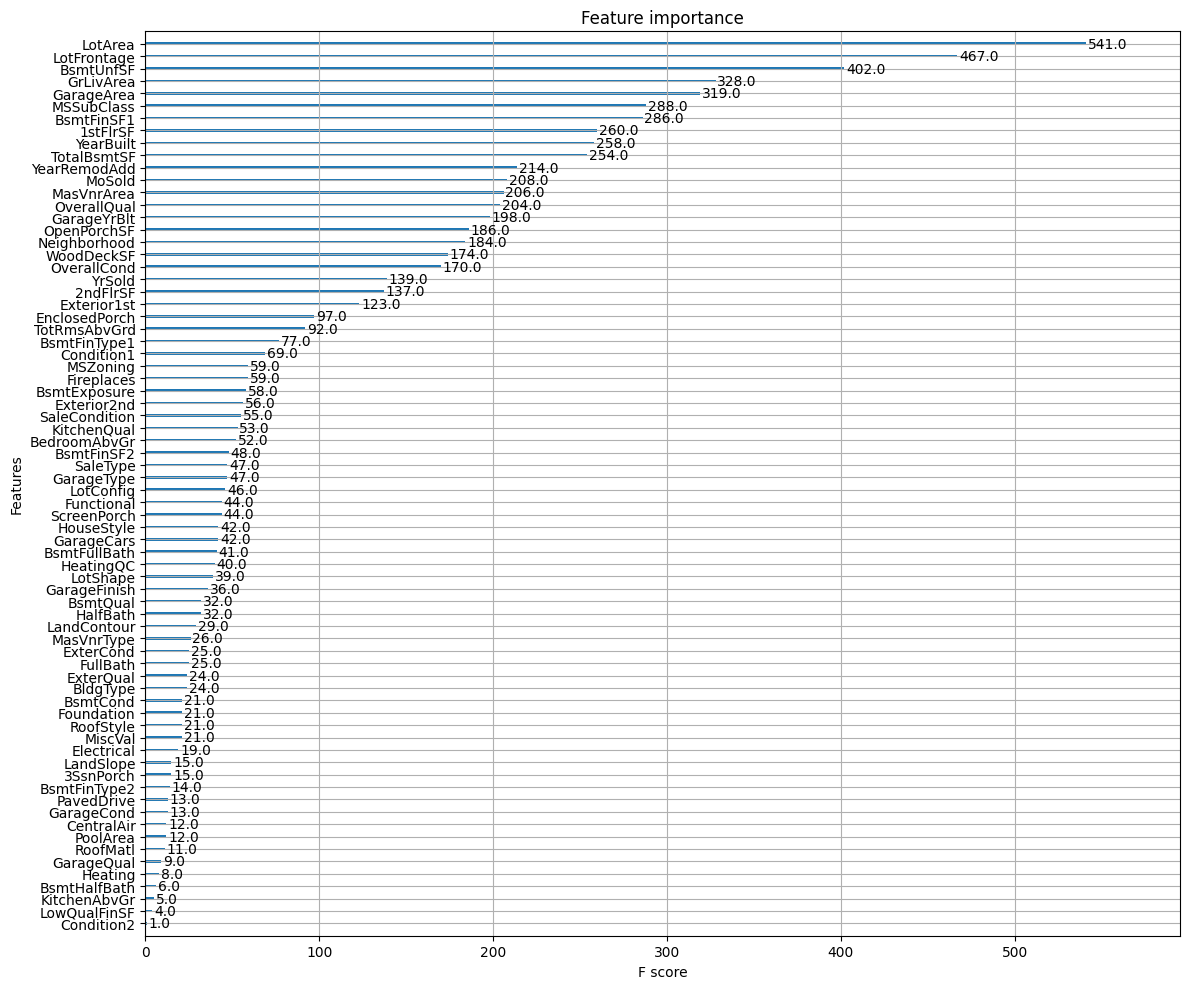

In [203]:
# 獲取特徵重要性
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 印出最重要的五個特徵之重要性
print(importance_df[:5])

# 可視化特徵重要性
fig, ax = plt.subplots(figsize=(12, 10))  # 設置圖像大小 (寬, 高)
xgb.plot_importance(model, importance_type='weight', ax=ax)
plt.tight_layout()
plt.show()

最重要的五個特徵為:
* LotArea
* LotFrontage
* MSSubClass
* OverallQual
* OverallCond  
改用只用這幾個特徵去訓練看看

In [204]:
top5 = importance_df['Feature'][:5].values

# 取出最重要的五個特徵
features = df[top5]
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(features, prices, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# 讀取數據 (DMatrix為xgboost專用的數據格式，可以優化訓練過程)
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
dtest = xgb.DMatrix(features)

# 設置參數
params = {
    "max_depth":5, 
    "eta":0.1, 
    "colsample_bytree":0.8, 
    "subsample":0.8, 
    "objective": "reg:squarederror"  # 設置為回歸任務
}
# 訓練模型
model = xgb.train(params=params, dtrain=dtrain,  num_boost_round=500, 
                  early_stopping_rounds=50, evals=[(dvalid, 'valid')])

# 預測
result2 = model.predict(dtest)

[0]	valid-rmse:0.36147
[1]	valid-rmse:0.34623
[2]	valid-rmse:0.32165
[3]	valid-rmse:0.29971
[4]	valid-rmse:0.28120
[5]	valid-rmse:0.26570
[6]	valid-rmse:0.25234
[7]	valid-rmse:0.24012
[8]	valid-rmse:0.23370
[9]	valid-rmse:0.22353
[10]	valid-rmse:0.21564
[11]	valid-rmse:0.20894
[12]	valid-rmse:0.20311
[13]	valid-rmse:0.19828
[14]	valid-rmse:0.19428
[15]	valid-rmse:0.19213
[16]	valid-rmse:0.18968
[17]	valid-rmse:0.18765
[18]	valid-rmse:0.18580
[19]	valid-rmse:0.18498
[20]	valid-rmse:0.18325
[21]	valid-rmse:0.18206
[22]	valid-rmse:0.18137
[23]	valid-rmse:0.18015
[24]	valid-rmse:0.17958
[25]	valid-rmse:0.17891
[26]	valid-rmse:0.17861
[27]	valid-rmse:0.17817
[28]	valid-rmse:0.17774
[29]	valid-rmse:0.17744
[30]	valid-rmse:0.17689
[31]	valid-rmse:0.17687
[32]	valid-rmse:0.17712
[33]	valid-rmse:0.17672
[34]	valid-rmse:0.17723
[35]	valid-rmse:0.17696
[36]	valid-rmse:0.17738
[37]	valid-rmse:0.17721
[38]	valid-rmse:0.17744
[39]	valid-rmse:0.17810
[40]	valid-rmse:0.17824
[41]	valid-rmse:0.17853
[4

In [205]:
restore_data(df, ID, result2, csv_name='hw2_house-prices_sol(5 features).csv')

       Feature  Importance
0   MSSubClass       341.0
1  LotFrontage       549.0
2      LotArea       728.0
3  OverallQual       277.0
4  OverallCond       242.0


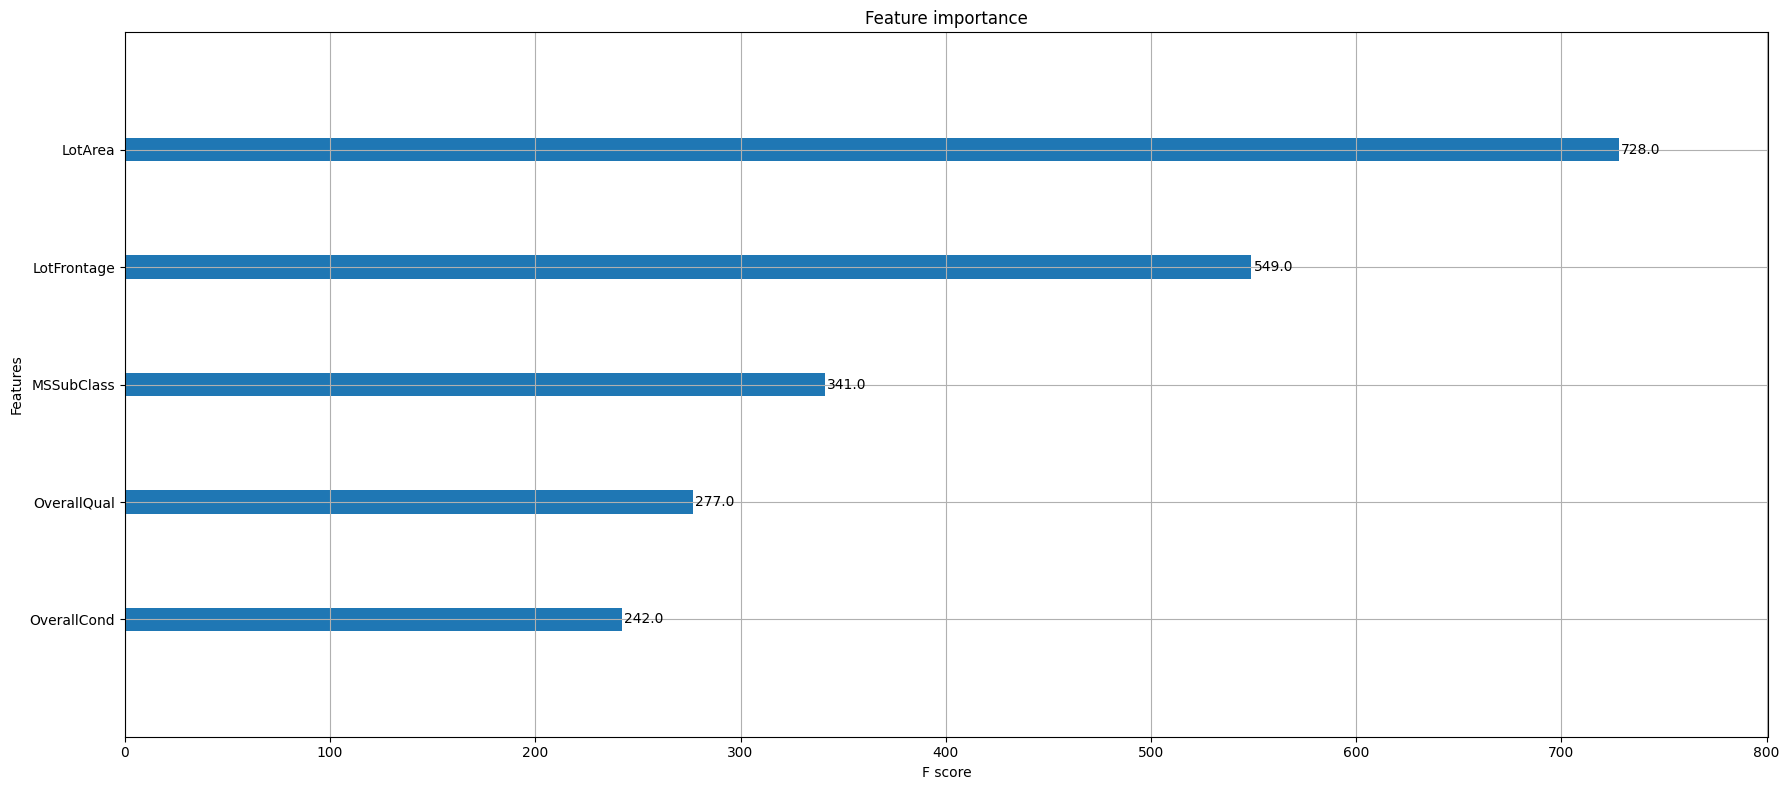

In [206]:
# 獲取特徵重要性
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 印出特徵重要性
print(importance_df)

# 可視化特徵重要性
fig, ax = plt.subplots(figsize=(18, 8))  # 設置圖像大小 (寬, 高)
xgb.plot_importance(model, importance_type='weight', ax=ax)
plt.tight_layout()
plt.show()

In [207]:
mse2 = mean_squared_error_original(y_true, result2)
mse2_log = mean_squared_error_log(y_true, result2)
print(f"Mean Squared Error for original data: {mse2}")
print(f"Mean Squared Error for log data: {mse2_log}")

Mean Squared Error for original data: 912307850.8139441
Mean Squared Error for log data: 0.020311917467769405


8. 兩結果比較

In [208]:
print(f"全部特徵的MSE: {mse}, log轉換後的MSE: {mse_log}")
print(f"最重要的五個特徵的MSE: {mse2}, log轉換後的MSE: {mse2_log}")
if mse >= mse2:
    print("使用五個最重要的特徵，均方誤差較小")
else:
    print("使用所有特徵，均方誤差較小")

全部特徵的MSE: 219474095.85702056, log轉換後的MSE: 0.0034523574258858753
最重要的五個特徵的MSE: 912307850.8139441, log轉換後的MSE: 0.020311917467769405
使用所有特徵，均方誤差較小


結論: 使用全部特徵預測較準確  
轉換為log數據的MSE，誤差較小，但轉換為原始數據後，誤差明顯變大，因此考慮全部特徵的模型而不考慮只選擇最重要的五個特徵較好。